In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm_notebook

import fannypack
from lib import panda_datasets, panda_baseline_models, panda_baseline_training
from lib.ekf import KalmanFilterNetwork
from fannypack import utils
from lib import dpf
from lib.panda_models import PandaDynamicsModel, PandaEKFMeasurementModel
from lib.fusion import CrossModalWeights
import lib.panda_kf_training as training
from lib.fusion import KalmanFusionModel



In [3]:
# Experiment configuration
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [4]:
experiment_names = ["fusion_sigma_final_1", "fusion_weighted_final_1", "fusion_poe_final_1"]
fusion_type = ["sigma", "weighted", "poe"]


In [5]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)

# eval_trajectories = eval_trajectories[70:90]

In [6]:
# image_modality_model
image_measurement = PandaEKFMeasurementModel(missing_modalities=['gripper_sensors'], units=64)
image_dynamics = PandaDynamicsModel(use_particles=False)
image_model = KalmanFilterNetwork(image_dynamics, image_measurement)

# force_modality_model
force_measurement = PandaEKFMeasurementModel(missing_modalities=['image'], units=64)
force_dynamics = PandaDynamicsModel(use_particles=False)
force_model = KalmanFilterNetwork(force_dynamics, force_measurement)

weight_model = CrossModalWeights()

fusion_models = []
buddies = []

for i, f_type in enumerate(fusion_type):
    model = KalmanFusionModel(image_model, force_model, weight_model, fusion_type=f_type)
    buddy = fannypack.utils.Buddy(experiment_names[i],
                                  model,
                                optimizer_names=["im_meas", "force_meas",
                                "im_dynamics", "force_dynamics",
                                "force_ekf", "im_ekf",
                                "fusion"],
                                  load_checkpoint=True,
                                  )
    buddy.load_checkpoint("phase_4_fusion")
    fusion_models.append(model)
    buddies.append(buddy)



[buddy-fusion_sigma_final_1] Using device: cuda
[buddy-fusion_sigma_final_1] Read checkpoint from path: checkpoints/fusion_sigma_final_1-0000000000087555.ckpt
[buddy-fusion_sigma_final_1] Loaded checkpoint at step: 87555


/scr-ssd/filter/fannypack/fannypack/utils/_buddy_mixins/_checkpointing.py:252: UserWarning: Checkpoint loading: overriding optimizer names.
  warnings.warn("Checkpoint loading: overriding optimizer names.")


[buddy-fusion_sigma_final_1] Read checkpoint from path: checkpoints/fusion_sigma_final_1-phase_4_fusion.ckpt
[buddy-fusion_sigma_final_1] Loaded checkpoint at step: 87555
[buddy-fusion_weighted_final_1] Using device: cuda
[buddy-fusion_weighted_final_1] Read checkpoint from path: checkpoints/fusion_weighted_final_1-0000000000087555.ckpt
[buddy-fusion_weighted_final_1] Loaded checkpoint at step: 87555
[buddy-fusion_weighted_final_1] Read checkpoint from path: checkpoints/fusion_weighted_final_1-phase_4_fusion.ckpt
[buddy-fusion_weighted_final_1] Loaded checkpoint at step: 87555
[buddy-fusion_poe_final_1] Using device: cuda
[buddy-fusion_poe_final_1] Loaded metadata: {'batch': 128, 'epochs': 5, 'hidden_units': 64, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'loading checkpoint': None, 'many loss': False, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'start training from': 'fusion', 'use_haptics': True, 'use_mass': False, 'use_proprioception': True

In [7]:
pred_list = []
actual_list = []

In [9]:
for i in range(len(fusion_models)):
    print("Fusion Model: {}".format(fusion_type[i])) 
    pred, actual = training.rollout_kf(fusion_models[i], eval_trajectories, 
                                       true_initial=True, init_state_noise=0.2)
    pred_list.append(pred)
    actual_list.append(actual)
    print("")

Fusion Model: sigma
(10, 240, 2)

Fusion Model: weighted
(10, 240, 2)

Fusion Model: poe
(10, 240, 2)



No handles with labels found to put in legend.


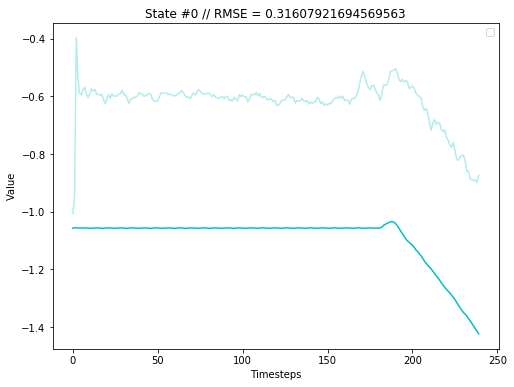

No handles with labels found to put in legend.


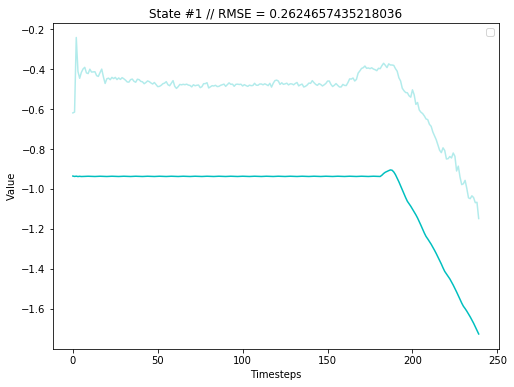

No handles with labels found to put in legend.


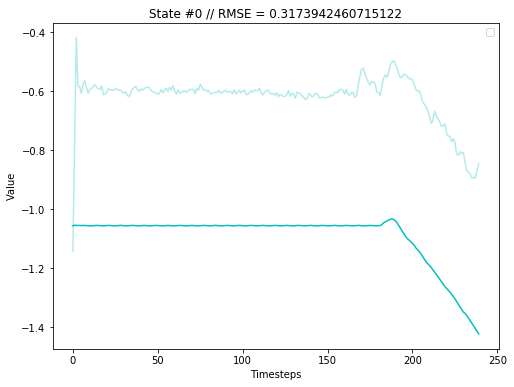

No handles with labels found to put in legend.


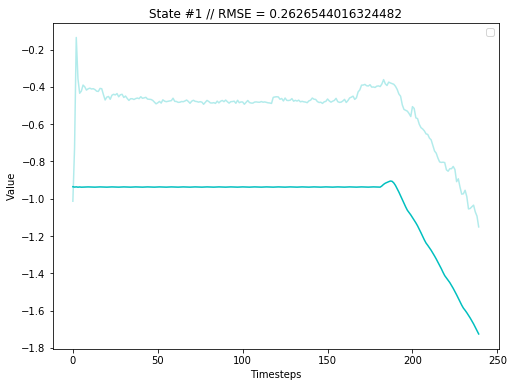

No handles with labels found to put in legend.


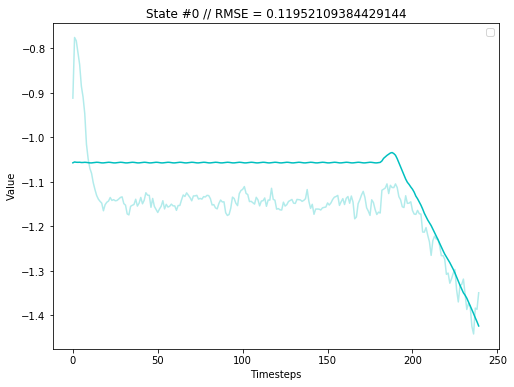

No handles with labels found to put in legend.


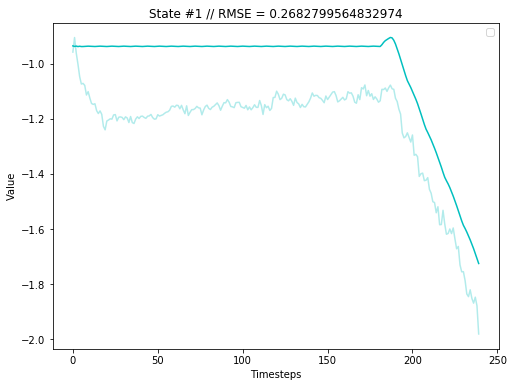

No handles with labels found to put in legend.


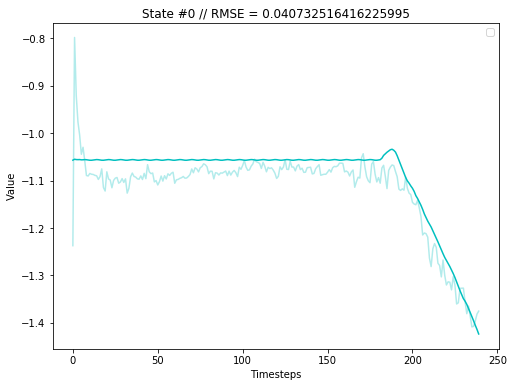

No handles with labels found to put in legend.


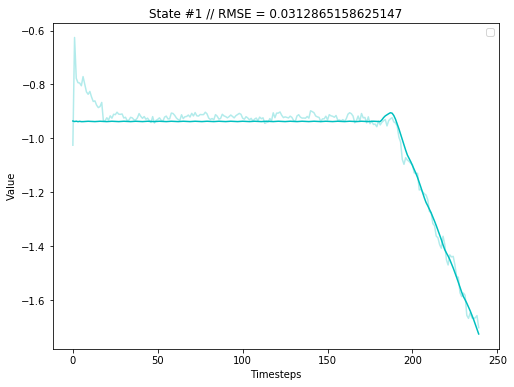

In [12]:
for i, (pred, actual) in enumerate(
                    zip(pred_list, actual_list)):
    
    training.eval_rollout(pred, actual, plot=True, plot_traj=[3], start=0)

fusion_sigma_final_1


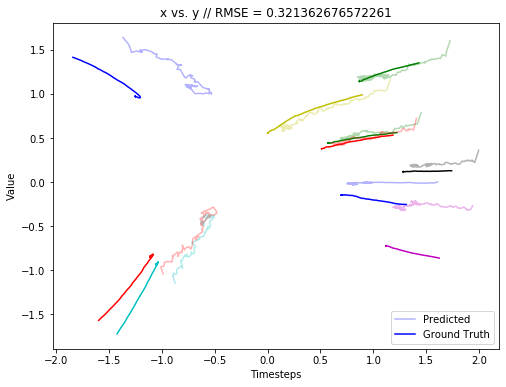

fusion_weighted_final_1


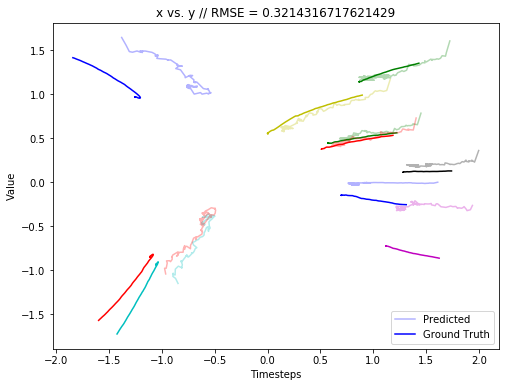

fusion_poe_final_1


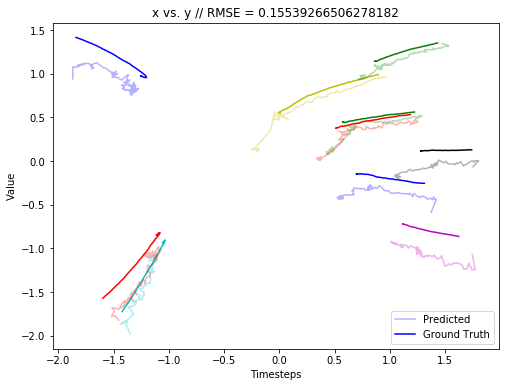

IndexError: list index out of range

In [13]:
for i, (pred, actual) in enumerate(
                    zip(pred_list, actual_list)):
    
    print(experiment_names[i])
    training.eval_2d_rollout(pred, actual, plot=True, start=150)

In [31]:

# for i in range(len(fusion_models)):
#     buddies[i].load_checkpoint("phase_4_fusion")

#     print("Fusion Model: {}".format(fusion_type[i])) 
#     pred, actual = training.rollout_kf(fusion_models[i], eval_trajectories, true_initial=True, init_state_noise=0.2)
#     training.eval_rollout(pred, actual, plot=True)
#     print("")

In [16]:
experiment_name = "ekf_1000_0"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}
measurement = PandaEKFMeasurementModel()
dynamics = PandaDynamicsModel(use_particles=False)
ekf = KalmanFilterNetwork(dynamics, measurement)
print("Creating model...")
buddy = fannypack.utils.Buddy(experiment_name,
                              ekf,
                              optimizer_names=["ekf", "dynamics", "measurement"],
                              load_checkpoint=True,
                              )

buddy.load_checkpoint("phase_3_e2e")

[autoreload of lib.panda_kf_training failed: Traceback (most recent call last):
  File "/scr-ssd/miniconda3/envs/filter/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/scr-ssd/miniconda3/envs/filter/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/scr-ssd/miniconda3/envs/filter/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/scr-ssd/miniconda3/envs/filter/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_

Creating model...
[buddy-ekf_1000_0] Using device: cuda
[buddy-ekf_1000_0] Read checkpoint from path: checkpoints/ekf_1000_0-0000000000039500.ckpt
[buddy-ekf_1000_0] Loaded checkpoint at step: 39500
[buddy-ekf_1000_0] Read checkpoint from path: checkpoints/ekf_1000_0-phase_3_e2e.ckpt
[buddy-ekf_1000_0] Loaded checkpoint at step: 39540


True

No handles with labels found to put in legend.


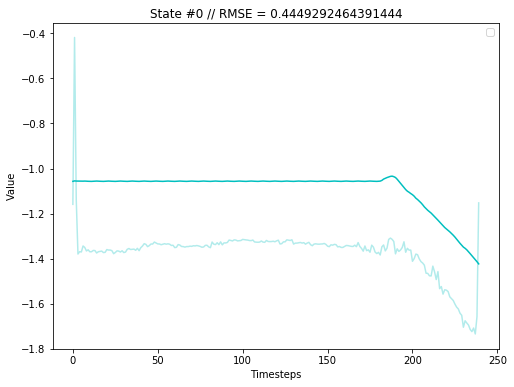

No handles with labels found to put in legend.


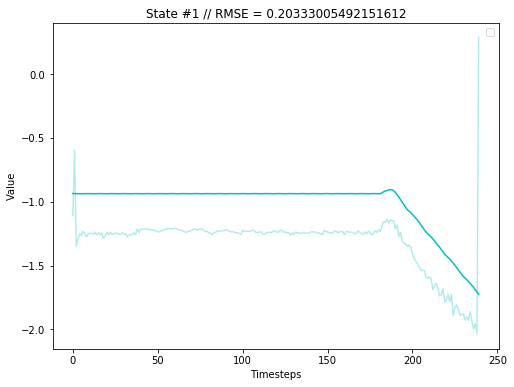

In [21]:
# pred, actual = training.rollout_kf(ekf, eval_trajectories, true_initial=True, init_state_noise=0.2)
training.eval_rollout(pred, actual, plot=True, plot_traj=[3])